# Project Title

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

Questions to consider:

- Who are your stakeholders?
- What are your stakeholders' pain points related to this project?
- Why are your predictions important from a business perspective?
- What exactly is your deliverable: your analysis, or the model itself?
- Does your business understanding/stakeholder require a specific type of model?
    - For example: a highly regulated industry would require a very transparent/simple/interpretable model, whereas a situation where the model itself is your deliverable would likely benefit from a more complex and thus stronger model
   

Additional questions to consider for classification:

- What does a false positive look like in this context?
- What does a false negative look like in this context?
- Which is worse for your stakeholder?
- What metric are you focusing on optimizing, given the answers to the above questions?

## Data Understanding

Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

In [1]:
#pip install missingno

In [2]:
#pip install category_encoders

In [3]:
import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve

import category_encoders as ce

In [4]:
!ls ../../Data

test_set_variables.csv     training_set_variables.csv
training_set_values.csv


In [5]:
#Read Target csv
df_variables = pd.read_csv("../../Data/training_set_variables.csv")
df_variables

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional
...,...,...
59395,60739,functional
59396,27263,functional
59397,37057,functional
59398,31282,functional


In [6]:
#Read Features csv
df_values = pd.read_csv("../../Data/training_set_values.csv")
df_values

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [7]:
#Merge the Features and Target DataFrames
df = df_variables.merge(df_values, left_on='id', right_on='id')
df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [8]:
df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [9]:
#Create a Target column of 0's and 1's
df['target'] = (df['status_group'] == 'functional').astype(int)

In [10]:
#Explore Target value counts
df['target'].value_counts()

1    32259
0    27141
Name: target, dtype: int64

In [11]:
#Explore Target percentages
df['target'].value_counts(normalize=True)

1    0.543081
0    0.456919
Name: target, dtype: float64

In [12]:
df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,target
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,1
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

In [14]:
#Explore Numeric columns
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,target
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475,0.543081
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547,0.498145
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000,1.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000,1.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,1.000000


In [15]:
#Explore Object columns
df[[c for c in df.columns if df[c].dtype == 'object']].describe()

,status_group,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,59400,59400,55765,55745,59400,59400,59029,59400,59400,59400,...,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,3,356,1897,2145,37400,9,19287,21,125,2092,...,7,8,6,5,5,10,7,3,7,6
top,functional,2011-03-15,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,...,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,32259,572,9084,17402,3563,10248,508,5294,2503,307,...,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625


In [16]:
#Number of unique values in the Object columns
df[[c for c in df.columns if df[c].dtype == 'object']].nunique()

status_group                 3
date_recorded              356
funder                    1897
installer                 2145
wpt_name                 37400
basin                        9
subvillage               19287
region                      21
lga                        125
ward                      2092
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
dtype: int64

In [17]:
#Explore the number of null values in each Column
df.isna().sum()

id                           0
status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_qu

In [18]:
df['extraction_type_class'].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

<AxesSubplot:>

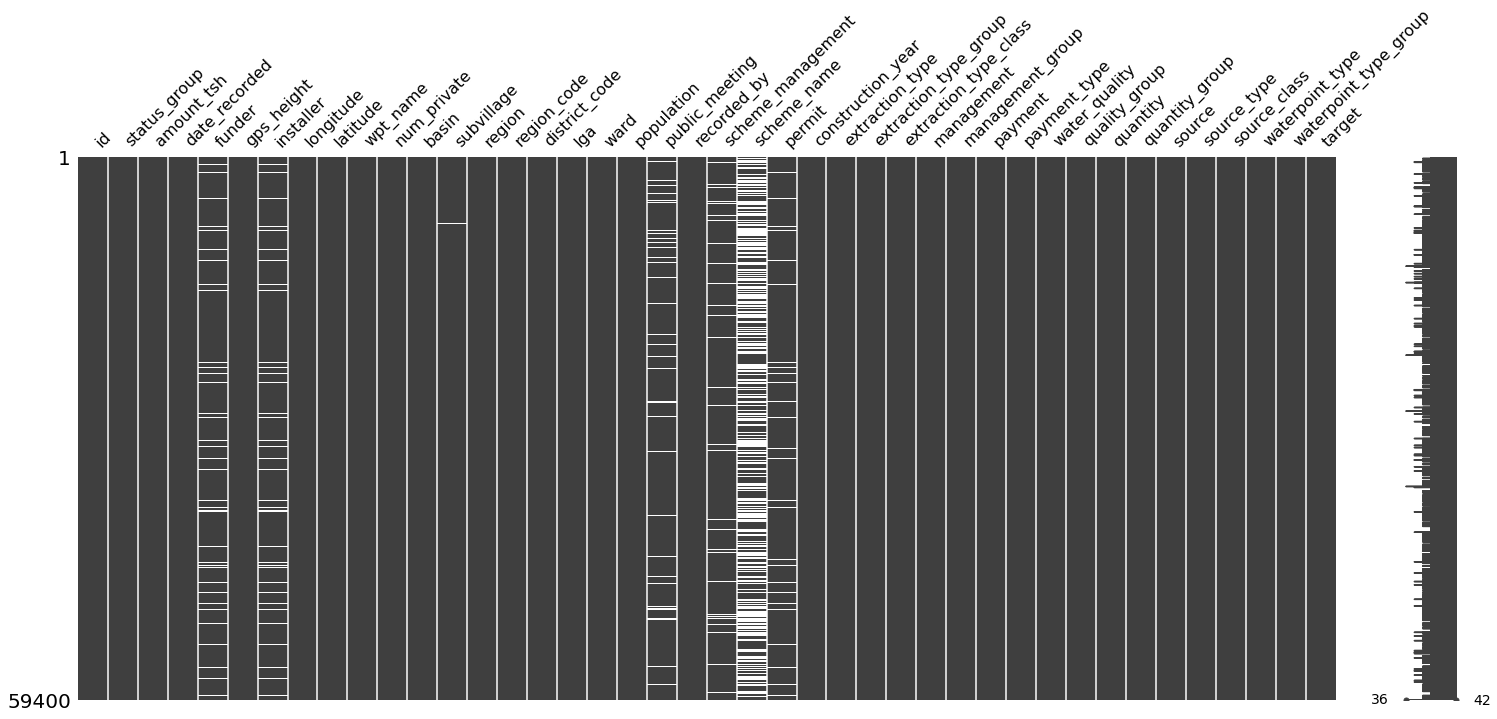

In [19]:
#Missing Value's matrix
msno.matrix(df)

## Data Preparation

Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?
- Can you pipeline your preparation steps to use them consistently in the modeling process?

### Train Test Split

In [20]:
# Define our X and y

X = df.drop(columns=['target', 'status_group'])
y = df['target']

# and train test split - to create our val holdout set!
X_tr, X_hold, y_tr, y_hold = train_test_split(X, y, test_size=0.1, # saving 10%
                                                  random_state=42)

# and 2nd train test split - to create our test set!
X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr, test_size=0.25, # saving 25%
                                                  random_state=42)

In [21]:
not_used_cols = ['waterpoint_type','subvillage', 'source_type', 'quantity_group',
                 'water_quality','payment_type','management', 'extraction_type', 
                 'extraction_type_group', 'scheme_name', 'region_code','id', 
                'longitude', 'latitude','date_recorded']
used_cols = ['amount_tsh', 'funder', 'gps_height', 'installer',
             'wpt_name', 'num_private', 'basin', 'subvillage', 
             'region', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 
             'recorded_by', 'scheme_management', 'permit', 'construction_year',
             'extraction_type_class', 'management_group', 'payment', 'quality_group',
             'quantity', 'source', 'source_class', 'waterpoint_type_group']

In [22]:
X_train_used_cols = X_train[used_cols]
X_test_used_cols = X_test[used_cols]

In [23]:
# Set up lists for columns requiring different treatment
num_cols = []
ohe_cols = []
freq_cols = []

for c in X_train_used_cols.columns:
    if X_train_used_cols[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X_train_used_cols[c].nunique() < 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)

In [24]:
print("NUMBER COLUMNS")
print(num_cols)
print('*'*10)
print("OHE COLUMNS")
print(ohe_cols)
print('*'*10)
print("FREQ COLUMNS")
print(freq_cols)

NUMBER COLUMNS
['amount_tsh', 'gps_height', 'num_private', 'district_code', 'population', 'construction_year']
**********
OHE COLUMNS
['basin', 'public_meeting', 'recorded_by', 'permit', 'extraction_type_class', 'management_group', 'payment', 'quality_group', 'quantity', 'source_class', 'waterpoint_type_group']
**********
FREQ COLUMNS
['funder', 'installer', 'wpt_name', 'subvillage', 'region', 'lga', 'ward', 'scheme_management', 'source']


In [25]:
print(X_train['public_meeting'].value_counts())
print(X_train['permit'].value_counts())

True     34442
False     3420
Name: public_meeting, dtype: int64
True     26216
False    11770
Name: permit, dtype: int64


In [26]:
#create a list of boolean columns
#This will help with the simple imputer
bool_cols=['public_meeting','permit']
ohe_cols.remove('public_meeting')
ohe_cols.remove('permit')
print(ohe_cols)

['basin', 'recorded_by', 'extraction_type_class', 'management_group', 'payment', 'quality_group', 'quantity', 'source_class', 'waterpoint_type_group']


In [27]:
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
    ])

bool_transformer = Pipeline(steps=[
    ('bool_imputer', SimpleImputer(strategy='constant', fill_value=False)),
    ('bool_encoder', OneHotEncoder(handle_unknown='error', drop='first'))
])

ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('oh_encoder', OneHotEncoder(handle_unknown='error', drop='first'))
])

freq_transformer = Pipeline(steps=[
    ('freq_imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('freq_encoder', ce.count.CountEncoder(normalize=True, min_group_size=.05))
])

In [28]:
# Package those pieces together using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('bool', bool_transformer, bool_cols),
        ('ohe', ohe_transformer, ohe_cols),
        ('freq', freq_transformer, freq_cols)
    ])


In [29]:
#preprocessor.fit(X_train_used_cols)

In [30]:
# code here to prepare your data

## Modeling

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How will you analyze the data to arrive at an initial approach?
- How will you iterate on your initial approach to make it better?
- What model type is most appropriate, given the data and the business problem?

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any relevant modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?
- What does this final model tell you about the relationship between your inputs and outputs?

### Baseline Understanding

- What does a baseline, model-less prediction look like?

In [31]:
# code here to arrive at a baseline prediction

In [32]:
y_train.value_counts()

1    21857
0    18238
Name: target, dtype: int64

In [33]:
y_train.value_counts(normalize=True)

1    0.54513
0    0.45487
Name: target, dtype: float64

### First $&(@# Model

Before going too far down the data preparation rabbit hole, be sure to check your work against a first 'substandard' model! What is the easiest way for you to find out how hard your problem is?

In [34]:
# code here for your first 'substandard' model

In [35]:
pipe_lg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(random_state=42))
])

In [36]:
cv = cross_validate(pipe_lg, X_train_used_cols, y_train, return_train_score=True)
cv

/Users/garrettwilliams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/garrettwilliams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

{'fit_time': array([1.11888671, 1.0958848 , 1.070292  , 1.03714824, 1.06059504]),
 'score_time': array([0.17776799, 0.11361098, 0.11284494, 0.11503077, 0.16569495]),
 'test_score': array([0.73500436, 0.72752213, 0.72914328, 0.72378102, 0.7232822 ]),
 'train_score': array([0.72914328, 0.73154383, 0.72982916, 0.73269734, 0.73176207])}

In [37]:
# code here to evaluate your first 'substandard' model

In [38]:
pipe_lg.fit(X_train_used_cols, y_train)

/Users/garrettwilliams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'num_private',
                                                   'district_code',
                                                   'population',
                                                   'construction_year']),
                                                 ('bool',
                                                  Pipeline(steps=[('bool_imputer',
                                                                   Sim

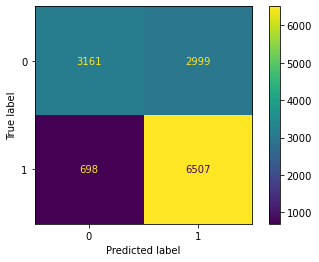

In [39]:
test_preds = pipe_lg.predict(X_test_used_cols)
test_probas = pipe_lg.predict_proba(X_test_used_cols)[:,1]
plot_confusion_matrix(pipe_lg, X_test_used_cols, y_test)

In [40]:
# More space to check more metrics
print("Training Scores:")
print(f"Train Accuracy: {accuracy_score(y_test, test_preds)}")
print(f"Train Precision: {precision_score(y_test, test_preds)}")
print(f"Train Roc-Auc Score: {roc_auc_score(y_test, test_probas)}")

Training Scores:
Train Accuracy: 0.7233819678264123
Train Precision: 0.6845150431306544
Train Roc-Auc Score: 0.7952510319312888


### Modeling Iterations

Now you can start to use the results of your first model to iterate - there are many options!

In [41]:
# code here to iteratively improve your models

In [42]:
# param_grid = {
#     "logreg__class_weight": ['balanced', None],
#     "logreg__max_iter": [500, 1000, 10000],
#     "logreg__c":[0.1, 1.0, 10.0],
#     "logreg__solver":['lbfgs','saga']
# }

In [43]:
#grid = GridSearchCV(pipe_lg, param_grid, scoring='precision')

In [44]:
#output = grid.fit(X_train, y_train)

In [45]:
#output.best_params_

In [46]:
#output.best_estimator_.fit(X_train, y_train)

In [47]:
# code here to evaluate your iterations

In [48]:
# test_preds = pipe_lg.predict(X_test_used_cols)
# test_probas = pipe_lg.predict_proba(X_test_used_cols)[:,1]
# plot_confusion_matrix(pipe_lg, X_test_used_cols, y_test)

In [49]:
# More space to check more metrics
print("Training Scores:")
print(f"Train Accuracy: {accuracy_score(y_test, test_preds)}")
print(f"Train Precision: {precision_score(y_test, test_preds)}")
print(f"Train Roc-Auc Score: {roc_auc_score(y_test, test_probas)}")

Training Scores:
Train Accuracy: 0.7233819678264123
Train Precision: 0.6845150431306544
Train Roc-Auc Score: 0.7952510319312888


### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [50]:
# code here to show your final model

In [51]:
# code here to evaluate your final model

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- How could the stakeholder use your model effectively?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
